# Univariate with exogenous variables

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.dates as mdates
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sktime.forecasting.var import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split

warnings.filterwarnings("ignore")

In [2]:
data_case = pd.read_csv("../data/data_2023-Nov-16.csv")
data_case.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2023-11-14,355,21003340,NaN,19370997,NaN,1631595.0
1,nation,England,E92000001,2023-11-13,606,21002985,198.0,19370997,177.0,1631595.0
2,nation,England,E92000001,2023-11-12,531,21002379,276.0,19370799,210.0,1631418.0
3,nation,England,E92000001,2023-11-11,210,21001848,132.0,19370523,57.0,1631208.0
4,nation,England,E92000001,2023-11-10,150,21001638,80.0,19370391,32.0,1631151.0


In [3]:
data_case = data_case[["date", "newCasesBySpecimenDate"]]
data_case = data_case.rename(columns={"newCasesBySpecimenDate": "new_cases"})
data_case["date"] = pd.to_datetime(data_case["date"])
data_case = data_case.set_index("date")
data_case.head()

,new_cases
date,
2023-11-14,355
2023-11-13,606
2023-11-12,531
2023-11-11,210
2023-11-10,150


In [4]:
data_death = pd.read_csv("../data/data_2023-Nov-16 (2).csv")
data_death.head()

,areaType,areaName,areaCode,date,newDailyNsoDeathsByDeathDate,cumDailyNsoDeathsByDeathDate
0,nation,England,E92000001,2023-10-20,45,196386
1,nation,England,E92000001,2023-10-19,48,196341
2,nation,England,E92000001,2023-10-18,45,196293
3,nation,England,E92000001,2023-10-17,50,196248
4,nation,England,E92000001,2023-10-16,39,196198


In [5]:
data_mv = pd.read_csv("../data/data_2023-Nov-16 (4).csv")
data_mv.head()

,areaType,areaName,areaCode,date,covidOccupiedMVBedsWeekly
0,nation,England,E92000001,2023-05-26,79
1,nation,England,E92000001,2023-05-19,92
2,nation,England,E92000001,2023-05-12,102
3,nation,England,E92000001,2023-05-05,100
4,nation,England,E92000001,2023-04-28,94


In [6]:
data_vacc = pd.read_csv("../data/data_2023-Nov-16 (5).csv")
data_vacc.head()

,areaType,areaName,areaCode,date,newVaccinesGivenByPublishDate,cumVaccinesGivenByPublishDate,newPeopleVaccinatedFirstDoseByPublishDate,cumPeopleVaccinatedFirstDoseByPublishDate,newPeopleVaccinatedSecondDoseByPublishDate,cumPeopleVaccinatedSecondDoseByPublishDate,newPeopleVaccinatedThirdInjectionByPublishDate,cumPeopleVaccinatedThirdInjectionByPublishDate
0,nation,England,E92000001,2023-11-15,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
1,nation,England,E92000001,2023-11-14,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
2,nation,England,E92000001,2023-11-13,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
3,nation,England,E92000001,2023-11-12,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
4,nation,England,E92000001,2023-11-11,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0


In [7]:
# Creating the dataframe from the provided data
admission_data = pd.DataFrame(
    {
        "AgeGroup": ["85+", "65 - 84", "6 - 17", "18 - 64", "0 - 5"],
        "AdmissionsUnsorted": [238128, 443513, 15230, 366215, 24881],
        "AdmissionRateUnsorted": [16931.6, 4896.6, 186.5, 1077.3, 633.3],
    }
)

# Sorting the data as requested
admission_data_sorted = admission_data.sort_values(by=["AgeGroup"], ascending=True)
# Save the sorted DataFrame to a CSV file
admission_data_sorted.to_csv("../data/sorted_admissions_data.csv", index=False)

In [8]:
admission_data_sorted

,AgeGroup,AdmissionsUnsorted,AdmissionRateUnsorted
4,0 - 5,24881,633.3
3,18 - 64,366215,1077.3
2,6 - 17,15230,186.5
1,65 - 84,443513,4896.6
0,85+,238128,16931.6


In [9]:
fil_dt = pd.read_csv("../data/filtered_data.csv")
fil_dt.head()

,areaCode,areaName,areaType,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
0,E40000007,East of England,nhsRegion,2023-05-31,5.0,105345,262.0,40
1,E40000007,East of England,nhsRegion,2023-05-30,3.0,105305,252.0,40
2,E40000007,East of England,nhsRegion,2023-05-29,4.0,105265,258.0,51
3,E40000007,East of England,nhsRegion,2023-05-28,6.0,105214,261.0,32
4,E40000007,East of England,nhsRegion,2023-05-27,8.0,105182,263.0,27


In [10]:
fil_dt["date"] = pd.to_datetime(fil_dt["date"])
agg_fil_dt = fil_dt.groupby(["date"]).sum()
agg_fil_dt.head()

,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
date,,,,
2020-04-02,1494.0,26264,12135.0,2932
2020-04-03,1788.0,28828,13635.0,2564
2020-04-04,1950.0,31421,15469.0,2593
2020-04-05,2097.0,34013,16657.0,2592
2020-04-06,2264.0,36692,17154.0,2679


In [11]:
agg_fil_dt.to_csv("../data/agg_filtered_data.csv")

In [12]:
# File paths for the CSV files
file_paths = [
    "../data/data_2023-Nov-16.csv",
    "../data/data_2023-Nov-16 (1).csv",
    "../data/data_2023-Nov-16 (2).csv",
    "../data/data_2023-Nov-16 (3).csv",
    "../data/data_2023-Nov-16 (4).csv",
    "../data/data_2023-Nov-16 (5).csv",
    "../data/agg_filtered_data.csv",
]

# Loading the datasets
datasets = [pd.read_csv(file) for file in file_paths]

# Selecting relevant columns from each dataset
# Dataset 6 (agg_filtered_data.csv) - MV Beds Occupied (Daily), Hospital Cases & New Admissions
mv_beds_occupied = datasets[6][["date", "covidOccupiedMVBeds"]]
hospital_cases = datasets[6][["date", "hospitalCases"]]
new_admissions = datasets[6][["date", "newAdmissions"]]

# Dataset 0 - New COVID-19 Cases
new_cases = datasets[0][["date", "newCasesBySpecimenDate"]]

# Dataset 2 - New COVID-19 Deaths
new_deaths = datasets[2][["date", "newDailyNsoDeathsByDeathDate"]]

# Dataset 5 - New Vaccinations
new_vaccinations = datasets[5][["date", "newVaccinesGivenByPublishDate"]]

# Merging all datasets on the 'date' column
combined_data = pd.merge(mv_beds_occupied, hospital_cases, on="date", how="outer")
combined_data = pd.merge(combined_data, new_admissions, on="date", how="outer")
combined_data = pd.merge(combined_data, new_cases, on="date", how="outer")
combined_data = pd.merge(combined_data, new_deaths, on="date", how="outer")
combined_data = pd.merge(combined_data, new_vaccinations, on="date", how="outer")

# Ensuring 'date' column is in datetime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Renaming columns for clarity
combined_data.columns = [
    "Date",
    "MV Beds Occupied",
    "Hospital Cases",
    "New Admissions",
    "New COVID-19 Cases",
    "New COVID-19 Deaths",
    "New Vaccinations",
]

# Displaying the combined dataframe
combined_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,NaN
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,NaN
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,NaN
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,NaN
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,NaN


In [13]:
combined_data["New Vaccinations"] = combined_data["New Vaccinations"].fillna(0)
combined_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0


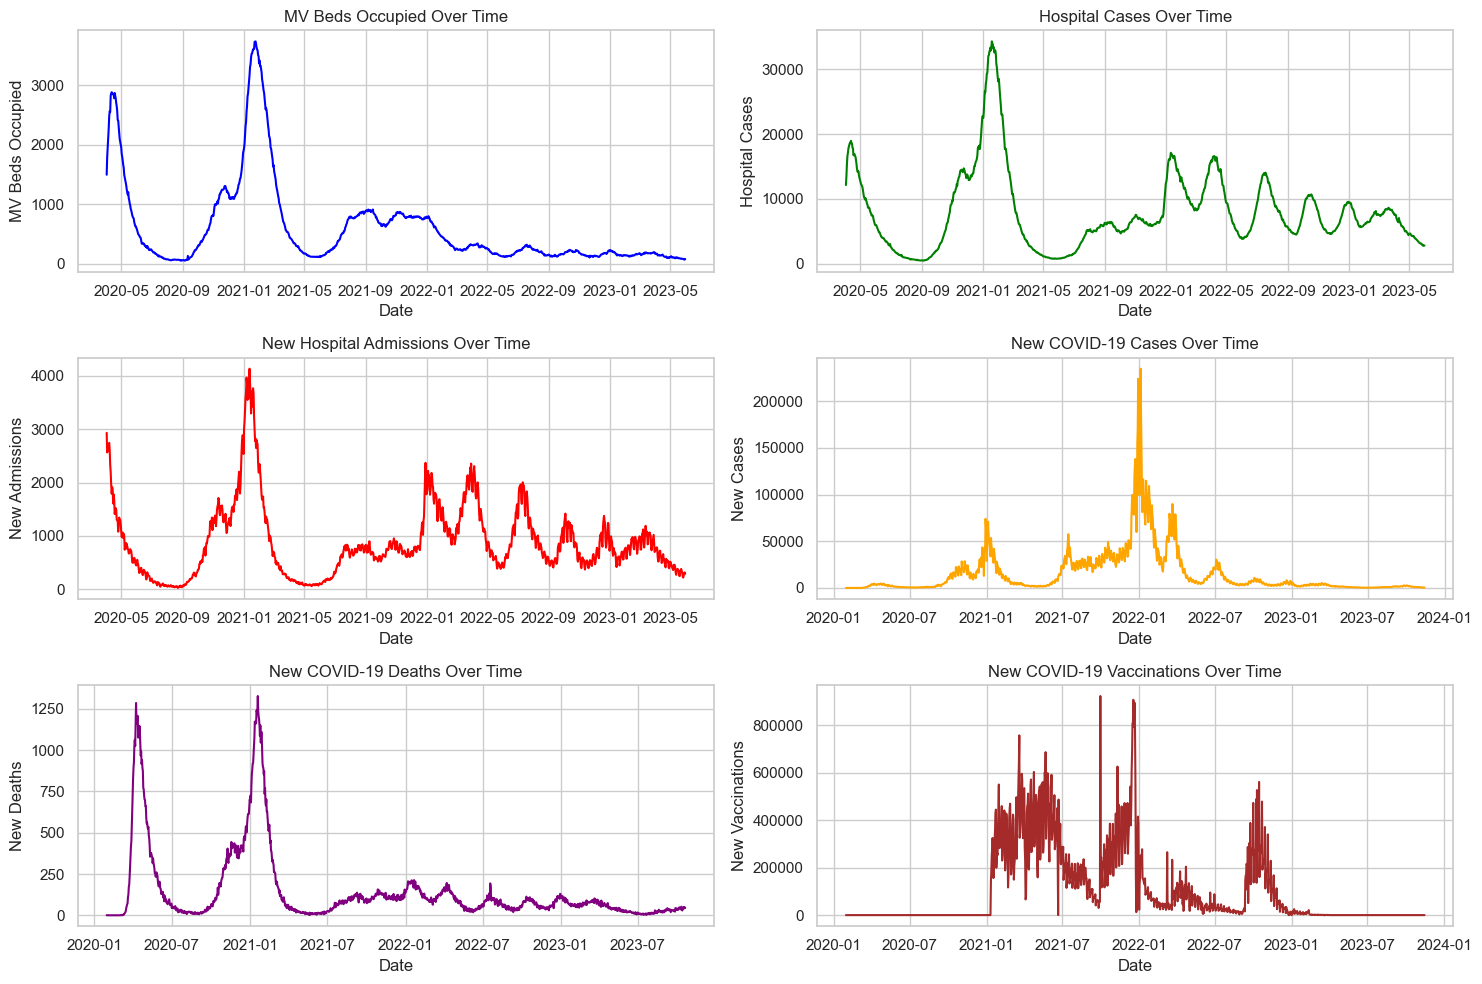

In [14]:
# Setting the visualization style
sns.set(style="whitegrid")

# Visualizing all the data
plt.figure(figsize=(15, 10))

# MV Beds Occupied
plt.subplot(3, 2, 1)
sns.lineplot(data=combined_data, x="Date", y="MV Beds Occupied", color="blue")
plt.title("MV Beds Occupied Over Time")
plt.xlabel("Date")
plt.ylabel("MV Beds Occupied")

# Hospital Cases
plt.subplot(3, 2, 2)
sns.lineplot(data=combined_data, x="Date", y="Hospital Cases", color="green")
plt.title("Hospital Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Hospital Cases")

# New Admissions
plt.subplot(3, 2, 3)
sns.lineplot(data=combined_data, x="Date", y="New Admissions", color="red")
plt.title("New Hospital Admissions Over Time")
plt.xlabel("Date")
plt.ylabel("New Admissions")

# New COVID-19 Cases
plt.subplot(3, 2, 4)
sns.lineplot(data=combined_data, x="Date", y="New COVID-19 Cases", color="orange")
plt.title("New COVID-19 Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")

# New COVID-19 Deaths
plt.subplot(3, 2, 5)
sns.lineplot(data=combined_data, x="Date", y="New COVID-19 Deaths", color="purple")
plt.title("New COVID-19 Deaths Over Time")
plt.xlabel("Date")
plt.ylabel("New Deaths")

# New Vaccinations
plt.subplot(3, 2, 6)
sns.lineplot(data=combined_data, x="Date", y="New Vaccinations", color="brown")
plt.title("New COVID-19 Vaccinations Over Time")
plt.xlabel("Date")
plt.ylabel("New Vaccinations")

plt.tight_layout()
plt.show()

In [15]:
# Define start and end date for the Alpha variant period
start_alpha = "2020-04-02"
end_alpha = "2021-12-30"

model_data = combined_data.loc[(combined_data["Date"] >= start_alpha) & (combined_data["Date"] <= end_alpha)]
model_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0


In [16]:
model_data.to_csv("../data/model_data.csv", index=False)

In [17]:
# Example for the High Infection Scenario
model_data["Year"] = model_data["Date"].dt.year
model_data["Month"] = model_data["Date"].dt.month
model_data["Day"] = model_data["Date"].dt.day

# Drop the original 'Date' column
model_data.drop("Date", axis=1, inplace=True)

In [18]:
X = model_data.drop(["MV Beds Occupied"], axis=1)
y = model_data["MV Beds Occupied"]

y.head()

0    1494.0
1    1788.0
2    1950.0
3    2097.0
4    2264.0
Name: MV Beds Occupied, dtype: float64

In [19]:
X.head()

,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Year,Month,Day
0,12135.0,2932.0,4097.0,892.0,0.0,2020,4,2
1,13635.0,2564.0,4102.0,927.0,0.0,2020,4,3
2,15469.0,2593.0,3405.0,1023.0,0.0,2020,4,4
3,16657.0,2592.0,3094.0,1063.0,0.0,2020,4,5
4,17154.0,2679.0,4407.0,1025.0,0.0,2020,4,6


In [20]:
fh = np.arange(1, 90)
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)
# fh = ForecastingHorizon(y_test.index, is_relative=False)

c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ajaoo\miniconda3\envs\py_env\lib\site-p

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='MV Beds Occupied'>)

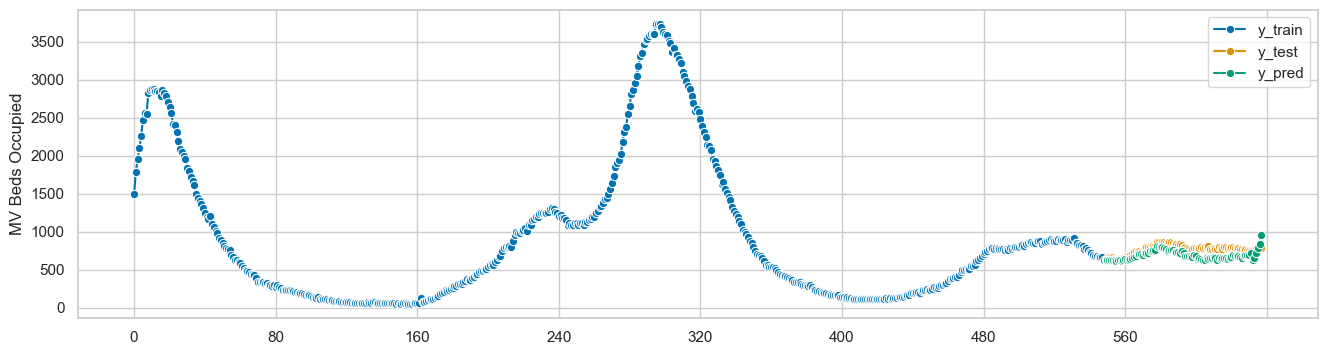

In [21]:
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Scenario Analysis in Forecasting Demand for Mechanical Ventilators

- **Scenerio A (high infection rate)**
- **Scenerio B (Increased Hospitalisation rate)**
- **Scenerio C (Efectiuve Vaccination Campaign)**
- **Scenerio D (Resource Strain)**


In [22]:
# Filter data for 2020 and early 2021
combined_data["Date"] = pd.to_datetime(combined_data["Date"])
data_2020_early_2021 = combined_data[
    (combined_data["Date"].dt.year == 2020)
    | ((combined_data["Date"].dt.year == 2021) & (combined_data["Date"].dt.month <= 4))
]

# High Infection and Hospitalization Scenario
data_high_infection = data_2020_early_2021.copy()
data_high_infection["New COVID-19 Cases"] *= 1.5
data_high_infection["New Admissions"] *= 1.5

# Effective Vaccination Scenario
data_effective_vaccination = data_2020_early_2021.copy()
data_effective_vaccination["New Admissions"] *= 0.7
data_effective_vaccination["MV Beds Occupied"] *= 0.7

# Resource Strain Scenario
data_resource_strain = data_2020_early_2021.copy()
data_resource_strain["Hospital Cases"] *= 1.25
data_resource_strain["MV Beds Occupied"] *= 1.25

In [23]:
data_high_infection.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,4398.0,6145.5,892.0,0.0
1,2020-04-03,1788.0,13635.0,3846.0,6153.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,3889.5,5107.5,1023.0,0.0
3,2020-04-05,2097.0,16657.0,3888.0,4641.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,4018.5,6610.5,1025.0,0.0


In [24]:
# Example for the High Infection Scenario
data_high_infection["Year"] = data_high_infection["Date"].dt.year
data_high_infection["Month"] = data_high_infection["Date"].dt.month
data_high_infection["Day"] = data_high_infection["Date"].dt.day

# Drop the original 'Date' column
data_high_infection.drop("Date", axis=1, inplace=True)

In [25]:
# Creating an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy="mean")

In [26]:
X = data_high_infection.drop("MV Beds Occupied", axis=1)
y = data_high_infection["MV Beds Occupied"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
X_train

,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Year,Month,Day
17,16928.0,2212.5,5241.0,967.0,0.0,2020,4,19
66,4820.0,484.5,1002.0,137.0,0.0,2020,6,7
1338,NaN,NaN,828.0,44.0,0.0,2020,3,16
320,17093.0,1966.5,16902.0,501.0,315797.0,2021,2,16
31,12119.0,1566.0,3972.0,556.0,0.0,2020,5,3
...,...,...,...,...,...,...,...,...
106,1346.0,124.5,822.0,31.0,0.0,2020,7,17
270,20426.0,4192.5,61267.5,615.0,0.0,2020,12,28
348,5664.0,546.0,7399.5,94.0,433751.0,2021,3,16
1363,NaN,NaN,0.0,0.0,0.0,2020,2,20


In [28]:
import pandas as pd
data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v3/location/GB_ENG.csv")

data.head(10)

,location_key,date,place_id,wikidata_id,country_code,country_name,subregion1_code,subregion1_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,...,facial_coverings,vaccination_policy,stringency_index,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
0,GB_ENG,2020-01-01,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,4.916667,1.847222,6.138889,0.108857,NaN,3.840278,92.753315
1,GB_ENG,2020-01-02,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,8.250000,5.673611,10.000000,0.000000,NaN,6.131944,86.523195
2,GB_ENG,2020-01-03,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.229167,4.381944,10.111111,0.465667,NaN,4.506944,82.876060
3,GB_ENG,2020-01-04,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,6.861111,4.187500,8.569444,0.217714,NaN,4.034722,82.214306
4,GB_ENG,2020-01-05,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.291667,4.625000,9.118056,0.000000,NaN,5.305556,87.216596
5,GB_ENG,2020-01-06,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.145833,4.805556,8.458333,0.000000,NaN,4.409722,82.768935
6,GB_ENG,2020-01-07,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,8.673611,3.444444,13.229167,0.423333,NaN,6.993056,89.209165
7,GB_ENG,2020-01-08,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,9.208333,5.743056,12.840278,0.203200,NaN,5.666667,78.549211
8,GB_ENG,2020-01-09,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.652778,4.750000,11.673611,12.107333,10.16,5.645833,87.136459
9,GB_ENG,2020-01-10,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,4.708333,2.500000,7.118056,0.666750,NaN,2.250000,84.126813


In [29]:
print(data.columns)

Index(['location_key', 'date', 'place_id', 'wikidata_id', 'country_code',
       'country_name', 'subregion1_code', 'subregion1_name',
       'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level',
       'new_confirmed', 'new_deceased', 'new_tested', 'cumulative_confirmed',
       'cumulative_deceased', 'cumulative_tested', 'new_hospitalized_patients',
       'cumulative_hospitalized_patients', 'current_hospitalized_patients',
       'current_ventilator_patients', 'new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated',
       'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered',
       'cumulative_vaccine_doses_administered', 'population',
       'population_male', 'population_female', 'population_age_00_09',
       'population_age_10_19', 'population_age_20_29', 'population_age_30_39',
       'population_age_40_49', 'population_age_50_59', 'population_age_60_69',
       'population_age_70_79', 'population_age_80_an

In [30]:
data.to_csv("../data/google_data.csv")

In [31]:
model_data = pd.read_csv("../data/model_data.csv")

In [32]:
additional_columns = ['date', 'stringency_index', 'average_temperature_celsius', 
                      'rainfall_mm', 'relative_humidity', 'vaccination_policy']

additional_features = data[additional_columns]

# Converting 'date' columns in both datasets to datetime for merging
additional_features['date'] = pd.to_datetime(additional_features['date'])
model_data['Date'] = pd.to_datetime(model_data['Date'])

# Merging the datasets on the date column
enriched_data = pd.merge(model_data, additional_features, left_on='Date', right_on='date', how='left')

# Dropping redundant date column
enriched_data.drop(columns='date', inplace=True)

# Display the first few rows of the enriched dataset
enriched_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,stringency_index,average_temperature_celsius,rainfall_mm,relative_humidity,vaccination_policy
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0,79.63,8.131944,0.0000,71.895232,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0,79.63,7.250000,0.0000,66.980840,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0,79.63,9.319444,0.0000,66.459780,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0,79.63,12.291667,0.0000,53.621480,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0,79.63,12.395833,0.3048,59.204766,0.0


In [33]:
enriched_data.to_csv("../data/full_data.csv")

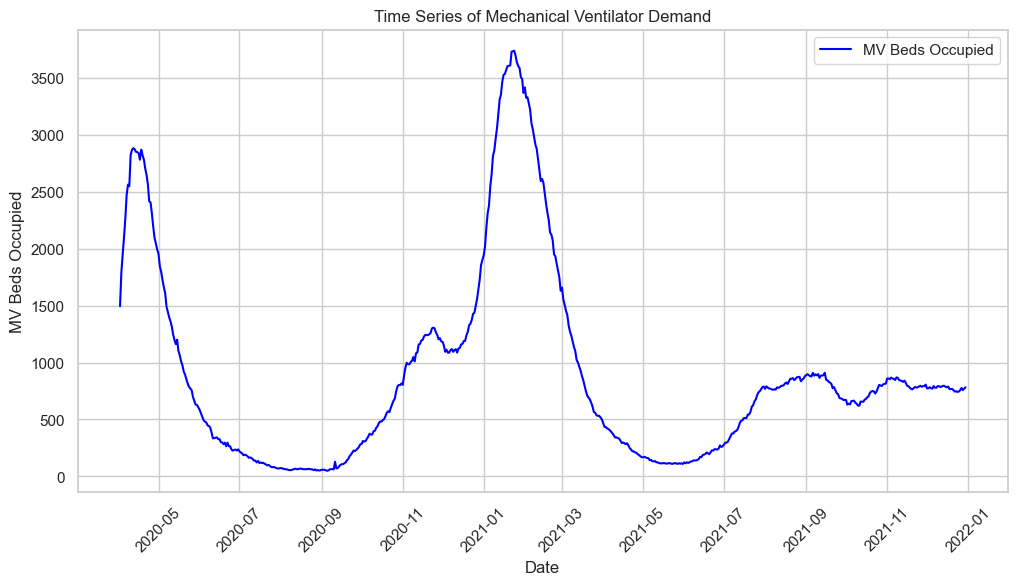

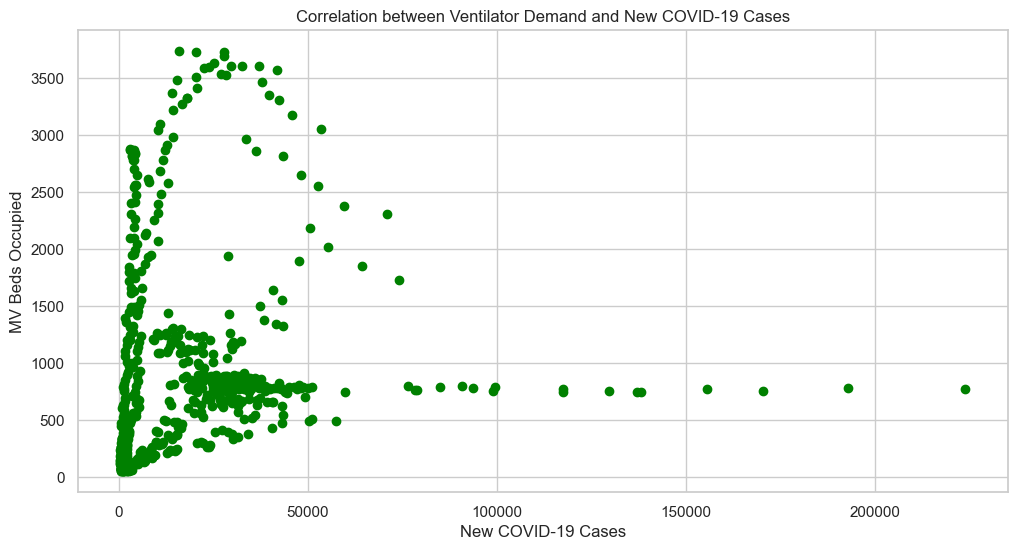

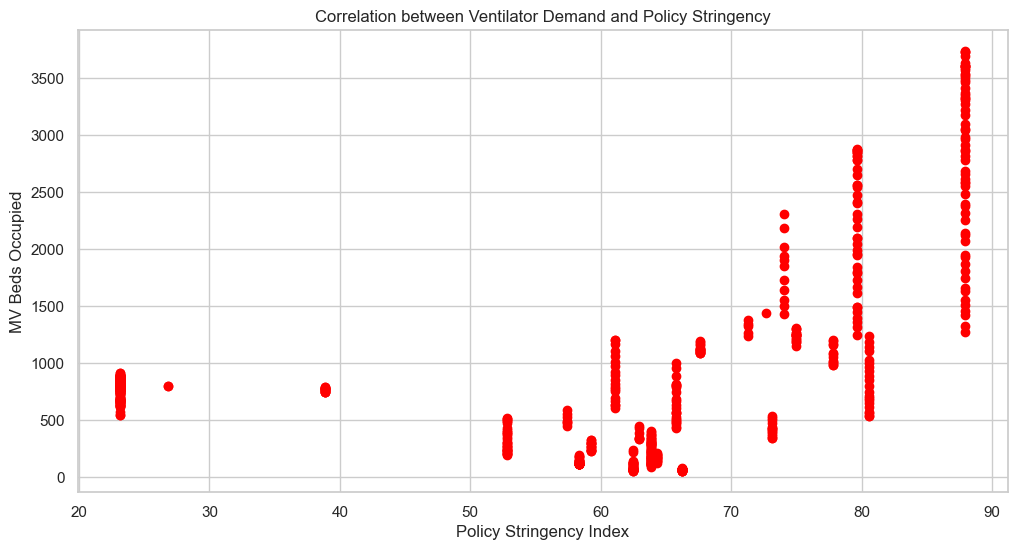

In [34]:
# Exploratory Data Analysis and Visualization

# Plotting time series of mechanical ventilator demand
plt.figure(figsize=(12, 6))
plt.plot(enriched_data['Date'], enriched_data['MV Beds Occupied'], label='MV Beds Occupied', color='blue')
plt.title('Time Series of Mechanical Ventilator Demand')
plt.xlabel('Date')
plt.ylabel('MV Beds Occupied')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting correlation between ventilator demand and new COVID-19 cases
plt.figure(figsize=(12, 6))
plt.scatter(enriched_data['New COVID-19 Cases'], enriched_data['MV Beds Occupied'], color='green')
plt.title('Correlation between Ventilator Demand and New COVID-19 Cases')
plt.xlabel('New COVID-19 Cases')
plt.ylabel('MV Beds Occupied')
plt.show()

# Plotting correlation between ventilator demand and policy stringency
plt.figure(figsize=(12, 6))
plt.scatter(enriched_data['stringency_index'], enriched_data['MV Beds Occupied'], color='red')
plt.title('Correlation between Ventilator Demand and Policy Stringency')
plt.xlabel('Policy Stringency Index')
plt.ylabel('MV Beds Occupied')
plt.show()


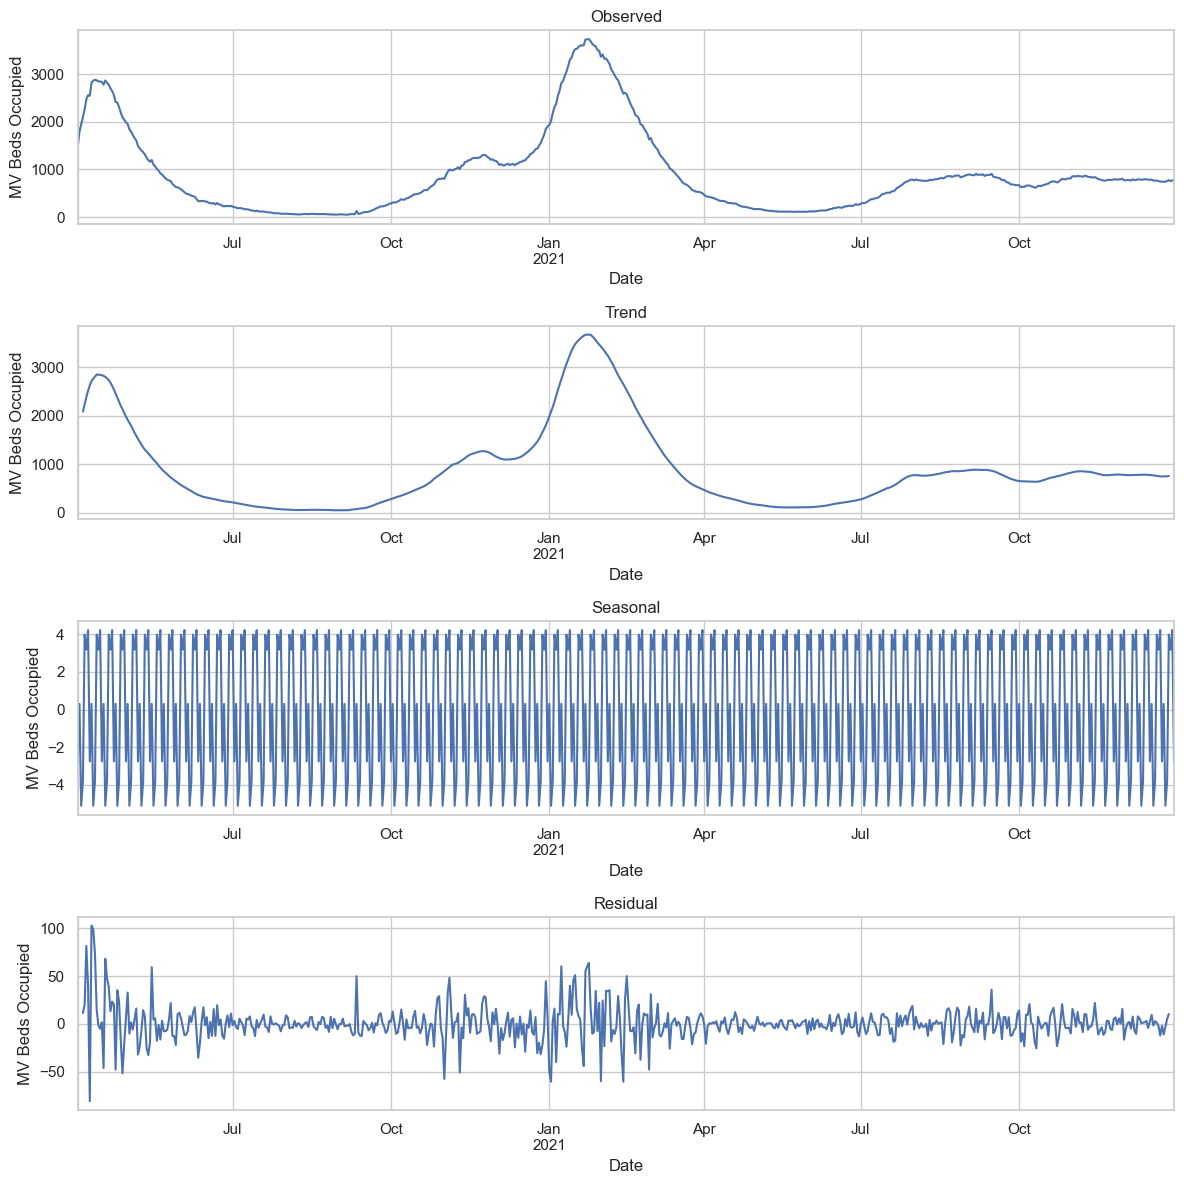

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series of mechanical ventilator demand
# Setting the model as 'additive' assuming linear relationship and constant seasonality over time
ts_data = enriched_data[['Date', 'MV Beds Occupied']].set_index('Date')
ts_data.dropna(inplace=True)  # Removing any NaN values for decomposition

# Assuming a weekly seasonality (7 days) for initial analysis
decomposition = seasonal_decompose(ts_data, model='additive', period=7)

# Plotting the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('MV Beds Occupied')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('MV Beds Occupied')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
ax3.set_ylabel('MV Beds Occupied')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
ax4.set_ylabel('MV Beds Occupied')

plt.tight_layout()
plt.show()


In [36]:
# Descriptive Statistics
descriptive_stats = enriched_data.describe()

# Missing Data Analysis
missing_data = enriched_data.isnull().sum()

# Displaying Descriptive Statistics and Missing Data
descriptive_stats, missing_data


(       MV Beds Occupied  Hospital Cases  New Admissions  New COVID-19 Cases  \
 count        638.000000      638.000000      638.000000          638.000000   
 mean         894.601881     7548.935737      814.036050        18180.184953   
 std          863.812152     7541.120299      811.756605        23704.324428   
 min           50.000000      451.000000       25.000000          351.000000   
 25%          238.500000     1811.750000      188.250000         2316.750000   
 50%          748.500000     5564.500000      650.500000        10968.500000   
 75%         1094.000000    10162.250000     1043.000000        27861.000000   
 max         3736.000000    34336.000000     4134.000000       224031.000000   
 
        New COVID-19 Deaths  New Vaccinations  stringency_index  \
 count           638.000000        638.000000        638.000000   
 mean            228.304075     171489.534483         57.763809   
 std             303.940130     198101.052232         21.624986   
 min      

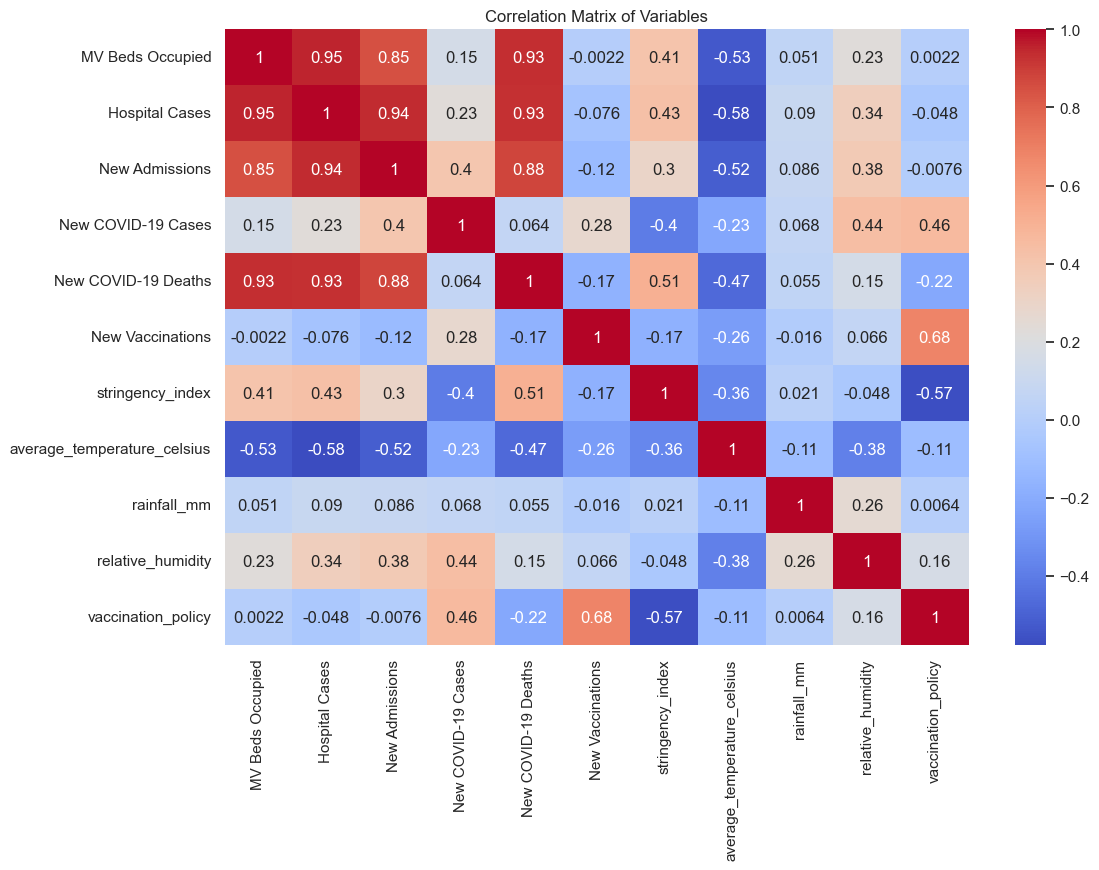

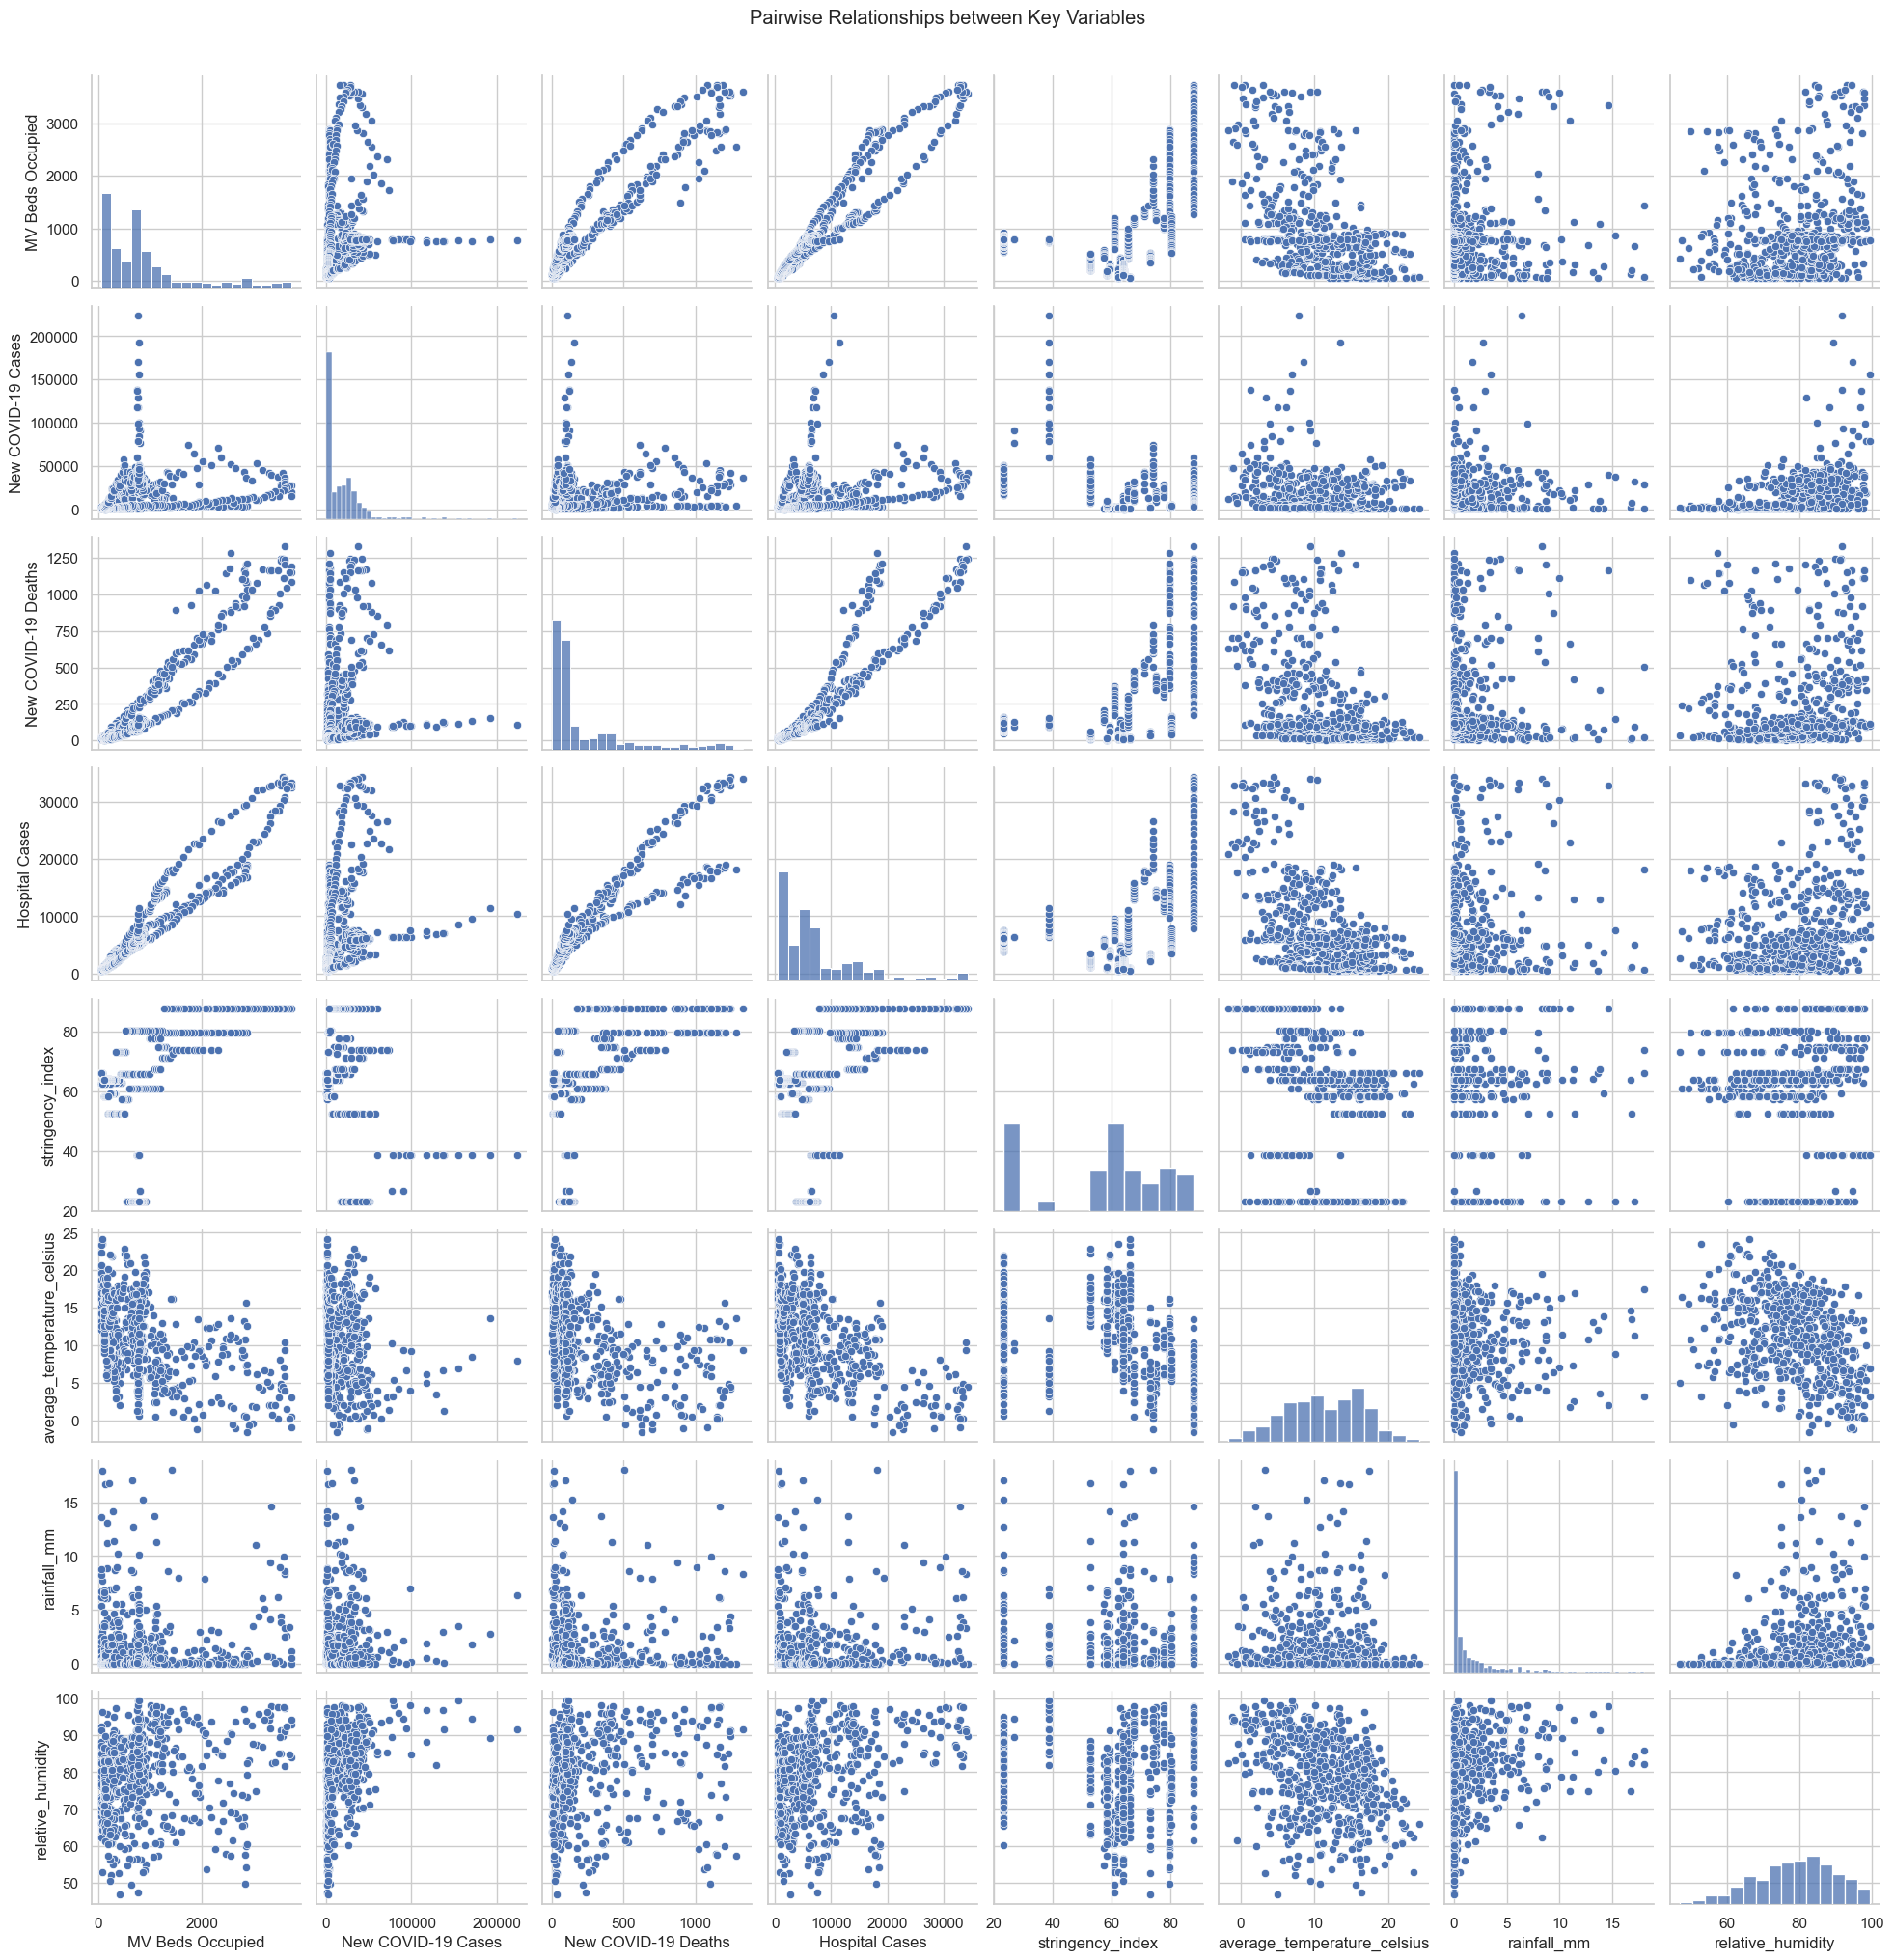

In [37]:
# Correlation Analysis
correlation_matrix = enriched_data.corr()

# Visualizing Correlation Matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Variables')
plt.show()

# Pairwise Relationships
# Selecting key variables for pairwise relationship analysis
pairwise_columns = ['MV Beds Occupied', 'New COVID-19 Cases', 'New COVID-19 Deaths', 
                    'Hospital Cases', 'stringency_index', 'average_temperature_celsius', 
                    'rainfall_mm', 'relative_humidity']

# Plotting pairwise relationships
sns.pairplot(enriched_data[pairwise_columns])
plt.suptitle('Pairwise Relationships between Key Variables', y=1.02)
plt.show()


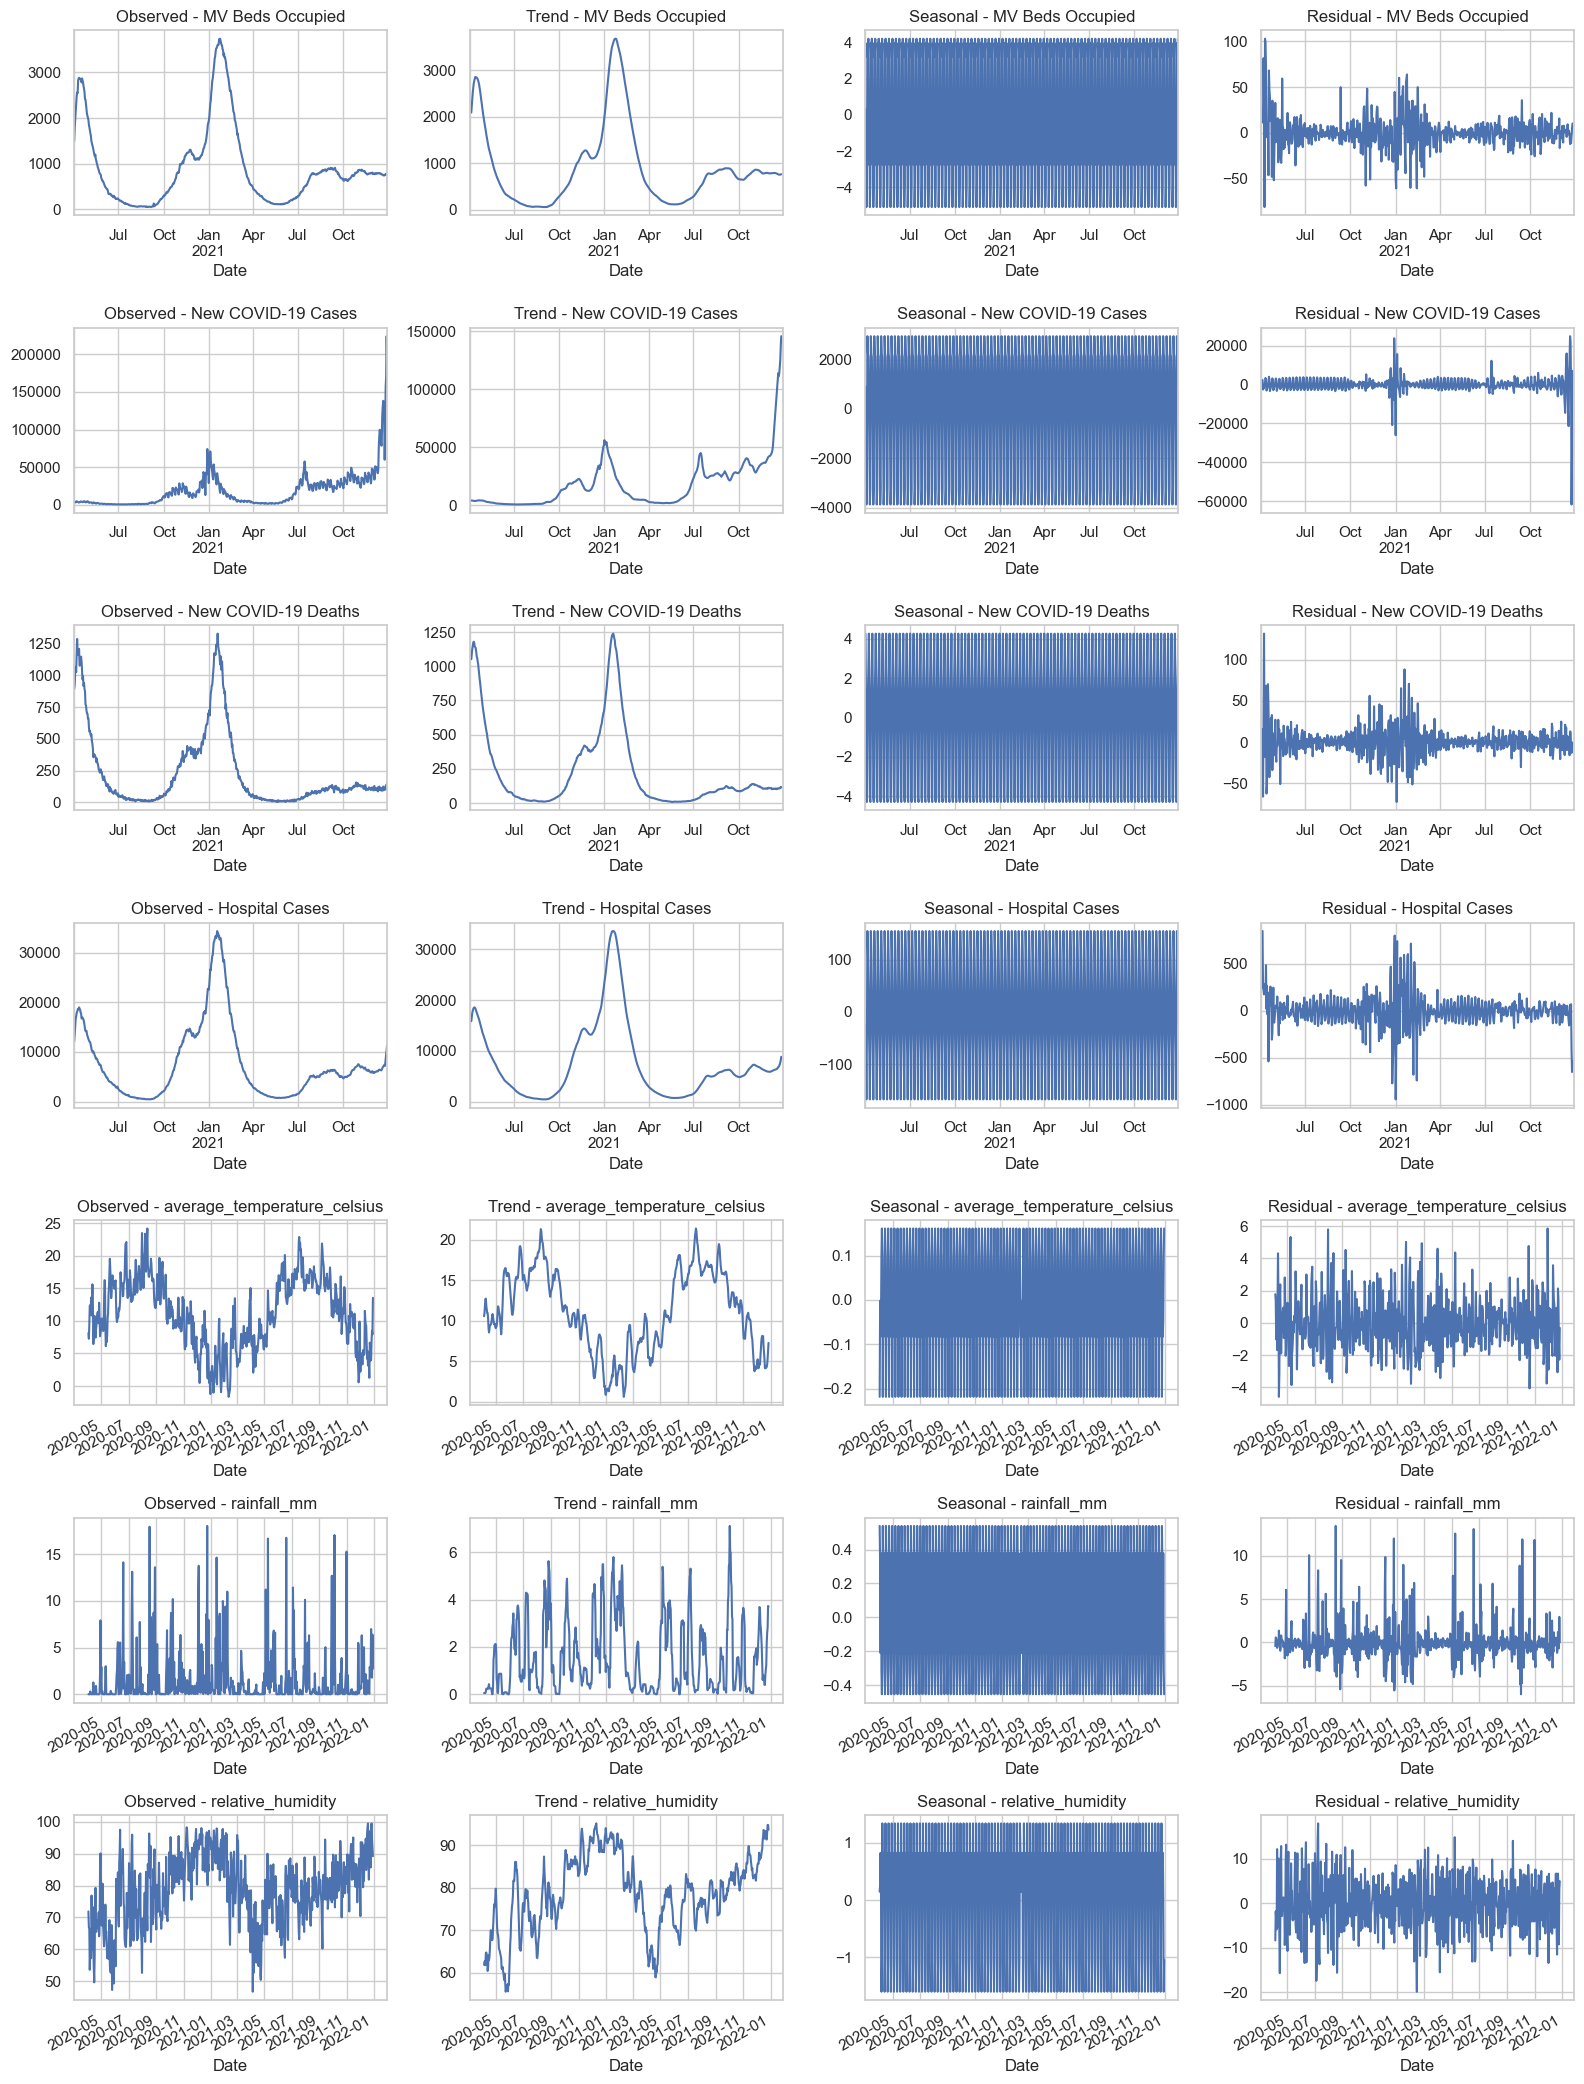

In [38]:
# Decomposing time series for each key variable
# Assuming a weekly seasonality (7 days) for initial analysis
decomposition_results = {}

for column in pairwise_columns:
    # Check if the column is a time series data (exclude stringency_index and vaccination_policy)
    if column not in ['stringency_index', 'vaccination_policy']:
        ts_data_column = enriched_data[['Date', column]].set_index('Date')
        ts_data_column.dropna(inplace=True)  # Removing NaN values for decomposition
        decomposition = seasonal_decompose(ts_data_column, model='additive', period=7)
        decomposition_results[column] = decomposition

# Plotting the decomposed components for each variable
fig, axes = plt.subplots(len(decomposition_results), 4, figsize=(16, 3 * len(decomposition_results)))

for i, (column, decomposition) in enumerate(decomposition_results.items()):
    decomposition.observed.plot(ax=axes[i, 0], title=f'Observed - {column}')
    decomposition.trend.plot(ax=axes[i, 1], title=f'Trend - {column}')
    decomposition.seasonal.plot(ax=axes[i, 2], title=f'Seasonal - {column}')
    decomposition.resid.plot(ax=axes[i, 3], title=f'Residual - {column}')

plt.tight_layout()
plt.show()


In [39]:
# Feature Engineering: Creating lagged variables, rolling averages, and other features

# Selecting key variables for feature engineering
selected_columns = ['MV Beds Occupied', 'New COVID-19 Cases', 'Hospital Cases', 'stringency_index', 
                    'average_temperature_celsius', 'rainfall_mm', 'relative_humidity']

# Creating lagged variables (e.g., lag of 7 days)
for column in selected_columns:
    enriched_data[f'{column}_lag7'] = enriched_data[column].shift(7)

# Creating rolling averages (e.g., 7-day rolling window)
for column in selected_columns:
    enriched_data[f'{column}_rolling7'] = enriched_data[column].rolling(window=7).mean()

# Additional feature: Day of the Week as a categorical variable
enriched_data['day_of_week'] = enriched_data['Date'].dt.dayofweek

# Displaying the first few rows of the dataset with new features
enriched_data.head()


,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,stringency_index,average_temperature_celsius,rainfall_mm,...,rainfall_mm_lag7,relative_humidity_lag7,MV Beds Occupied_rolling7,New COVID-19 Cases_rolling7,Hospital Cases_rolling7,stringency_index_rolling7,average_temperature_celsius_rolling7,rainfall_mm_rolling7,relative_humidity_rolling7,day_of_week
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0,79.63,8.131944,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0,79.63,7.250000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0,79.63,9.319444,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0,79.63,12.291667,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0,79.63,12.395833,0.3048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [49]:
# Function to add traces. This improves readability and makes the code easier to modify.
def add_trace(fig, x_data, y_data, color, title, row):
    fig.add_trace(
        go.Scatter(
            x=x_data,
            y=y_data,
            mode='lines',
            line=dict(color=color, width=2),
            name=title,
            showlegend=True  # Set to True to show legends
        ),
        row=row, col=1
    )

# Create a subplot with 4 rows
fig_trend = make_subplots(
    rows=6, cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.05,  # Adjust spacing between plots
    subplot_titles=(
        'Mechanical Ventilators Usage Over Time',
        'Daily Hospital Cases Over Time', 
        'Daily New Admissions Over Time'
        'Daily COVID-19 Cases Over Time',
        'New COVID-19 Deaths Over Time',
        "New Vaccinations"
        
    )
)

# Data for plotting
data = [
    (enriched_data['Date'], enriched_data['MV Beds Occupied'], 'blue', 'Mechanical Ventilators', 1),
    (enriched_data['Date'], enriched_data['Hospital Cases'], 'brown', 'Hospital Cases', 2),
    (enriched_data['Date'], model_data['New Admissions'], 'green', 'New Admissions', 3),
    (enriched_data['Date'], enriched_data['New COVID-19 Cases'], 'orange', 'New COVID-19 Cases', 4),
    (enriched_data['Date'], enriched_data['New COVID-19 Deaths'], 'red', 'New COVID-19 Deaths', 5),
    (enriched_data["Date"], enriched_data["New Vaccinations"], "purple", "New daily vaccination", 6)
]

# Add data to the subplot
for item in data:
    add_trace(fig_trend, *item)

# Update the layout for better appearance
fig_trend.update_layout(
    height=1200, 
    width=1000,  # Increased width for a better view
    template="plotly_white",
    title_text="Trend Analysis for Various COVID-19 Metrics",
    legend_title_text='Metrics',  # Add legend title
    hovermode="x unified"  # Unified hovermode for better tooltip display
)

# Update xaxis properties
fig_trend.update_xaxes(title_text="Date", row=4, col=1)

# Update yaxis properties
fig_trend.update_yaxes(title_text="Count", row=1, col=1)
fig_trend.update_yaxes(title_text="Count", row=2, col=1)
fig_trend.update_yaxes(title_text="Count", row=3, col=1)
fig_trend.update_yaxes(title_text="Count", row=4, col=1)
fig_trend.update_yaxes(title_text="Count", row=5, col=1)
fig_trend.update_yaxes(title_text="Count", row=6, col=1)
fig_trend.show()


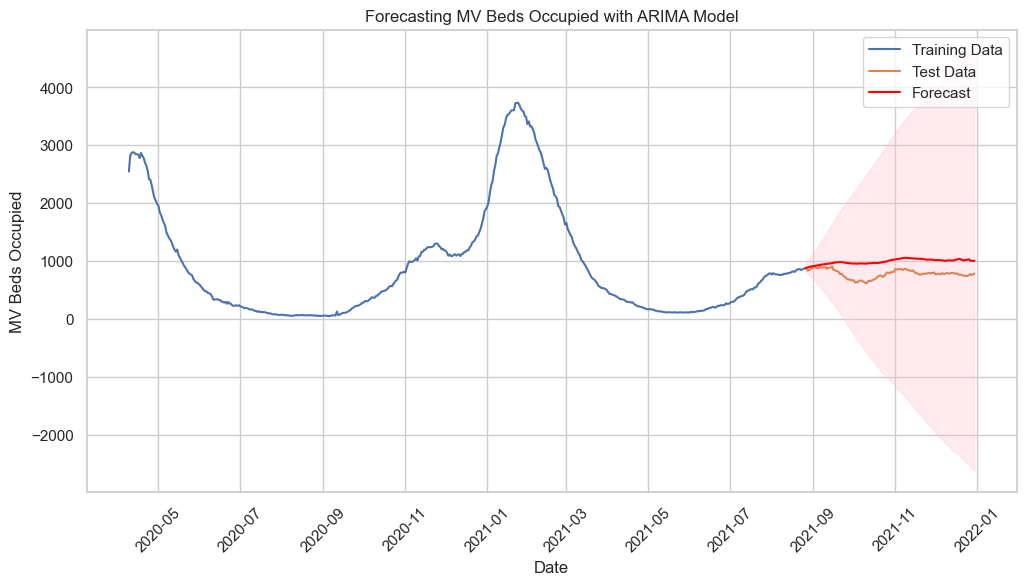

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import warnings

# Ignoring convergence warnings for demonstration purposes
warnings.filterwarnings("ignore")

# Preparing the dataset for ARIMA model
# Using 'MV Beds Occupied' as the target variable and a few selected features as exogenous variables
target = 'MV Beds Occupied'
exogenous_variables = ['New COVID-19 Cases_lag7', 'Hospital Cases_lag7', 'stringency_index_rolling7']

# Dropping rows with NaN values that were introduced due to lag/rolling features
arima_data = enriched_data.dropna(subset=[target] + exogenous_variables)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(arima_data, test_size=0.2, shuffle=False)

# Defining the ARIMA model
# For simplicity, using basic parameters and not performing extensive hyperparameter tuning
model = SARIMAX(train_data[target], exog=train_data[exogenous_variables], order=(1, 1, 1))

# Fitting the model
fitted_model = model.fit(disp=False)

# Forecasting
forecast = fitted_model.get_forecast(steps=len(test_data), exog=test_data[exogenous_variables])
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data[target], label='Training Data')
plt.plot(test_data['Date'], test_data[target], label='Test Data')
plt.plot(test_data['Date'], forecast_values, label='Forecast', color='red')
plt.fill_between(test_data['Date'], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecasting MV Beds Occupied with ARIMA Model')
plt.xlabel('Date')
plt.ylabel('MV Beds Occupied')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Hyperparameter tuning: Adjusting the order of the ARIMA model
# Trying a few different parameter combinations for demonstration
parameter_combinations = [(1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2), (3, 1, 1), (3, 1, 2), (4, 1, 1), (4, 1, 2), (5, 1, 1), (5, 1, 2)]
best_mae = np.inf
best_rmse = np.inf
best_order = None
best_model = None

for params in parameter_combinations:
    try:
        model = SARIMAX(train_data[target], exog=train_data[exogenous_variables], order=params)
        model_fit = model.fit(disp=False)

        # Forecasting
        forecast = model_fit.get_forecast(steps=len(test_data), exog=test_data[exogenous_variables])
        forecast_values = forecast.predicted_mean

        # Calculating metrics
        mae = mean_absolute_error(test_data[target], forecast_values)
        rmse = np.sqrt(mean_squared_error(test_data[target], forecast_values))

        if mae < best_mae and rmse < best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_order = params
            best_model = model_fit
    except:
        continue

# Best model's parameters and metrics
best_order, best_mae, best_rmse



((4, 1, 1), 143.2381252312141, 157.48972075404126)

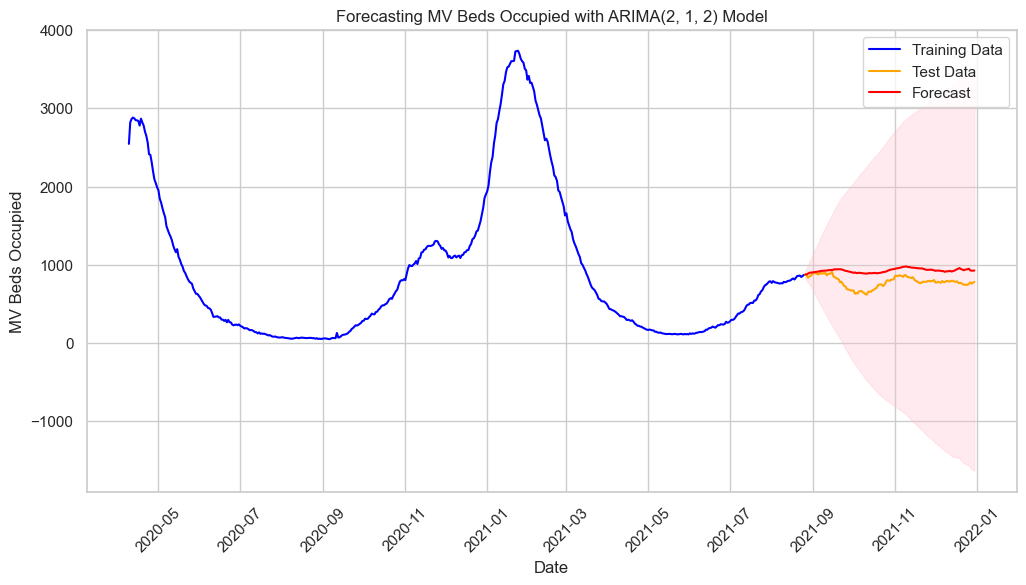

In [42]:
# Using the best model (ARIMA(2, 1, 2)) for forecasting and visualization
forecast = best_model.get_forecast(steps=len(test_data), exog=test_data[exogenous_variables])
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data[target], label='Training Data', color='blue')
plt.plot(test_data['Date'], test_data[target], label='Test Data', color='orange')
plt.plot(test_data['Date'], forecast_values, label='Forecast', color='red')
plt.fill_between(test_data['Date'], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecasting MV Beds Occupied with ARIMA(2, 1, 2) Model')
plt.xlabel('Date')
plt.ylabel('MV Beds Occupied')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preparing the dataset for Gradient Boosting model
# Using lagged and rolling features as predictors
predictors = [col for col in enriched_data.columns if 'lag7' in col or 'rolling7' in col]
predictors += ['day_of_week']

# Ensuring no NaN values in the dataset
ml_data = enriched_data.dropna(subset=[target] + predictors)

# Splitting the data into training and testing sets
train_ml_data, test_ml_data = train_test_split(ml_data, test_size=0.2, shuffle=False)

# Model Training
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gb_model.fit(train_ml_data[predictors], train_ml_data[target])

# Model Evaluation
train_predictions = gb_model.predict(train_ml_data[predictors])
test_predictions = gb_model.predict(test_ml_data[predictors])

# Calculating metrics
train_mae = mean_absolute_error(train_ml_data[target], train_predictions)
test_mae = mean_absolute_error(test_ml_data[target], test_predictions)
train_rmse = np.sqrt(mean_squared_error(train_ml_data[target], train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], test_predictions))

# Metrics
train_mae, test_mae, train_rmse, test_rmse


(8.665602447583147, 33.15823696448478, 11.648841346215868, 39.96110667323022)

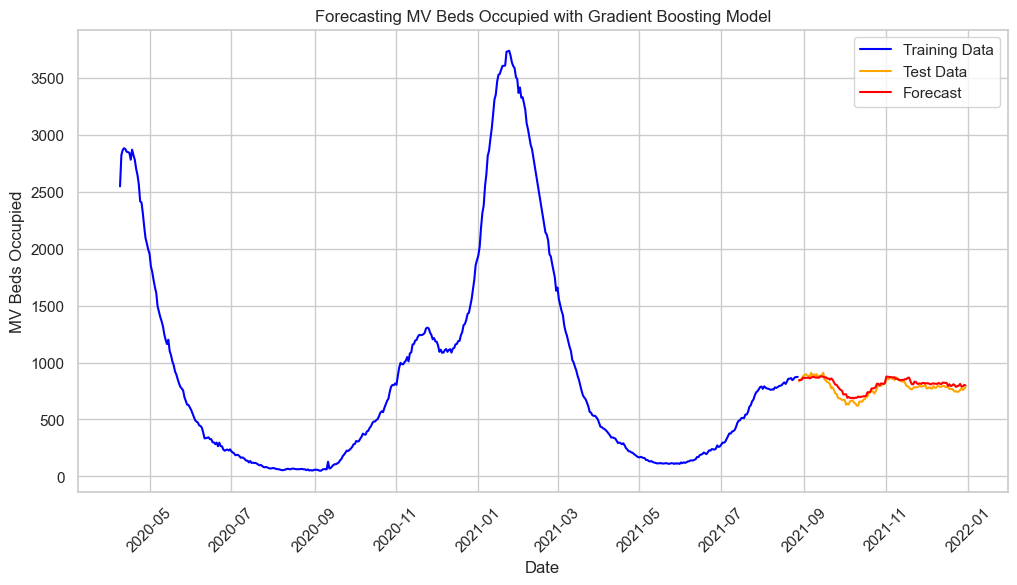

In [44]:
# Plotting the results of the Gradient Boosting model
plt.figure(figsize=(12, 6))
plt.plot(train_ml_data['Date'], train_ml_data[target], label='Training Data', color='blue')
plt.plot(test_ml_data['Date'], test_ml_data[target], label='Test Data', color='orange')
plt.plot(test_ml_data['Date'], test_predictions, label='Forecast', color='red')
plt.title('Forecasting MV Beds Occupied with Gradient Boosting Model')
plt.xlabel('Date')
plt.ylabel('MV Beds Occupied')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(train_ml_data[predictors], train_ml_data[target])
lr_train_predictions = lr_model.predict(train_ml_data[predictors])
lr_test_predictions = lr_model.predict(test_ml_data[predictors])

# Support Vector Regression Model
svr_model = SVR(kernel='rbf')
svr_model.fit(train_ml_data[predictors], train_ml_data[target])
svr_train_predictions = svr_model.predict(train_ml_data[predictors])
svr_test_predictions = svr_model.predict(test_ml_data[predictors])

# Metrics for Linear Regression
lr_train_mae = mean_absolute_error(train_ml_data[target], lr_train_predictions)
lr_test_mae = mean_absolute_error(test_ml_data[target], lr_test_predictions)
lr_train_rmse = np.sqrt(mean_squared_error(train_ml_data[target], lr_train_predictions))
lr_test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], lr_test_predictions))

# Metrics for Support Vector Regression
svr_train_mae = mean_absolute_error(train_ml_data[target], svr_train_predictions)
svr_test_mae = mean_absolute_error(test_ml_data[target], svr_test_predictions)
svr_train_rmse = np.sqrt(mean_squared_error(train_ml_data[target], svr_train_predictions))
svr_test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], svr_test_predictions))

# Compiling all metrics
metrics = {
    "Model": ["Gradient Boosting", "Linear Regression", "Support Vector Regression"],
    "Train MAE": [train_mae, lr_train_mae, svr_train_mae],
    "Test MAE": [test_mae, lr_test_mae, svr_test_mae],
    "Train RMSE": [train_rmse, lr_train_rmse, svr_train_rmse],
    "Test RMSE": [test_rmse, lr_test_rmse, svr_test_rmse]
}

metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,Train MAE,Test MAE,Train RMSE,Test RMSE
0,Gradient Boosting,8.665602,33.158237,11.648841,39.961107
1,Linear Regression,16.813498,28.102237,26.147396,46.400172
2,Support Vector Regression,609.115926,177.757054,957.560547,191.791909
